In [211]:
import pandas as pd
import numpy as np
import mne
import glob
from tqdm import tqdm

from EegHelper.EegData import EegDataPoint, EegDataset, files_to_datapoints
from EegHelper.DataIO import DataBuilder, split_main_data

#Popup MNE
%matplotlib qt

#Following two are so that external files are auto loaded after edit
%load_ext autoreload
%autoreload 2
#mne outputs so much stuff, so just set log level
mne.set_log_level('error')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
files = glob.glob('./MindBigData-EP-v1.0/*.csv')
all_points, all_labels = files_to_datapoints(files, first_n=500)

Loading epoc data...


100%|██████████| 500/500 [00:00<00:00, 618.59it/s]


In [61]:
for point in all_points:
    point.average_reference()
    point.filter_mne()
    point.crop_to_channels(channels=['T7', 'P7', 'P8', 'T8'])

In [224]:
from mne.decoding import Scaler
from EegHelper.EegAugmentation import NormalizationHelper, EegSmoothZeroMask
import matplotlib.pyplot as plt

In [58]:
helper = NormalizationHelper(all_points)           #Provide the data which you want to fit with
scaler = helper.get_robust_scaler()              #Get the fit scaler
all_points = NormalizationHelper.fit_points(scaler, all_points) #Fit points after providing scaler

100%|██████████| 498/498 [00:00<00:00, 674.76it/s]


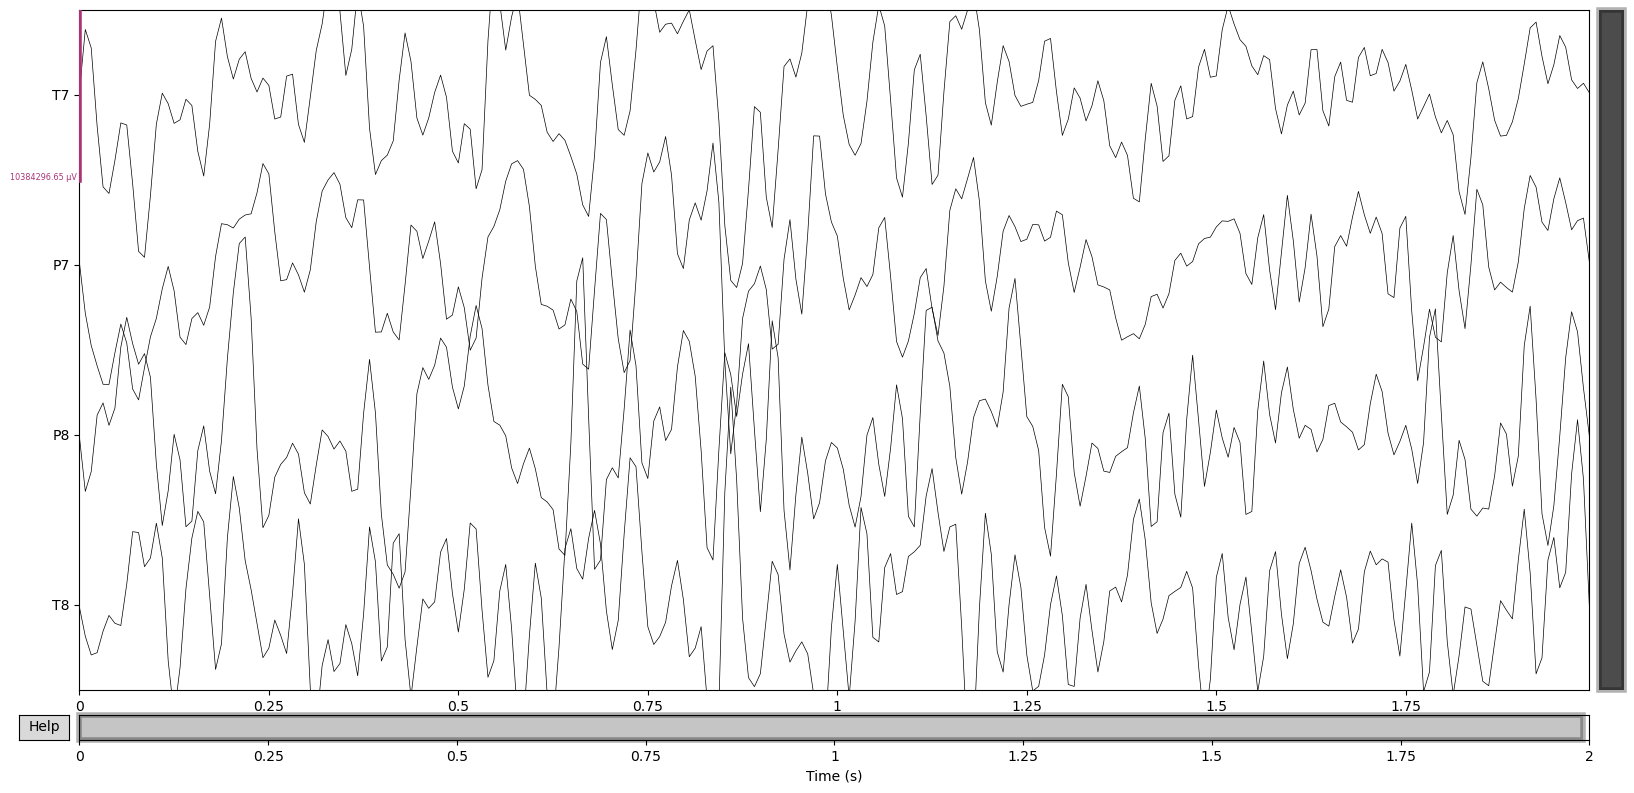

In [59]:
all_points[23].mne_object.plot(scalings='auto')

This is happening in the background of the NormalizationHelper.get_robust_scaler()

In [7]:
def get_all_epochs(data_points):
    epochs = []
    for point in data_points:
        epoch = point.get_full_epoch()._data
        epochs.append(epoch.reshape(epoch.shape[1], epoch.shape[2]))
    epochs = np.array(epochs)
    return epochs

scaler = Scaler(with_mean=True, with_std=True, scalings='mean')
scaler.fit(get_all_epochs(all_points))

AttributeError: 'EegDataPoint' object has no attribute 'get_full_epoch'

This is happening in fit points, except it returns a new array.

In [204]:
for point in all_points:
    data = scaler.transform(point.get_full_epoch()._data)
    data = data.reshape(data.shape[1], data.shape[2])
    point = EegDataPoint(
        data,
        point.label,
        ch_names=point.ch_names
    )

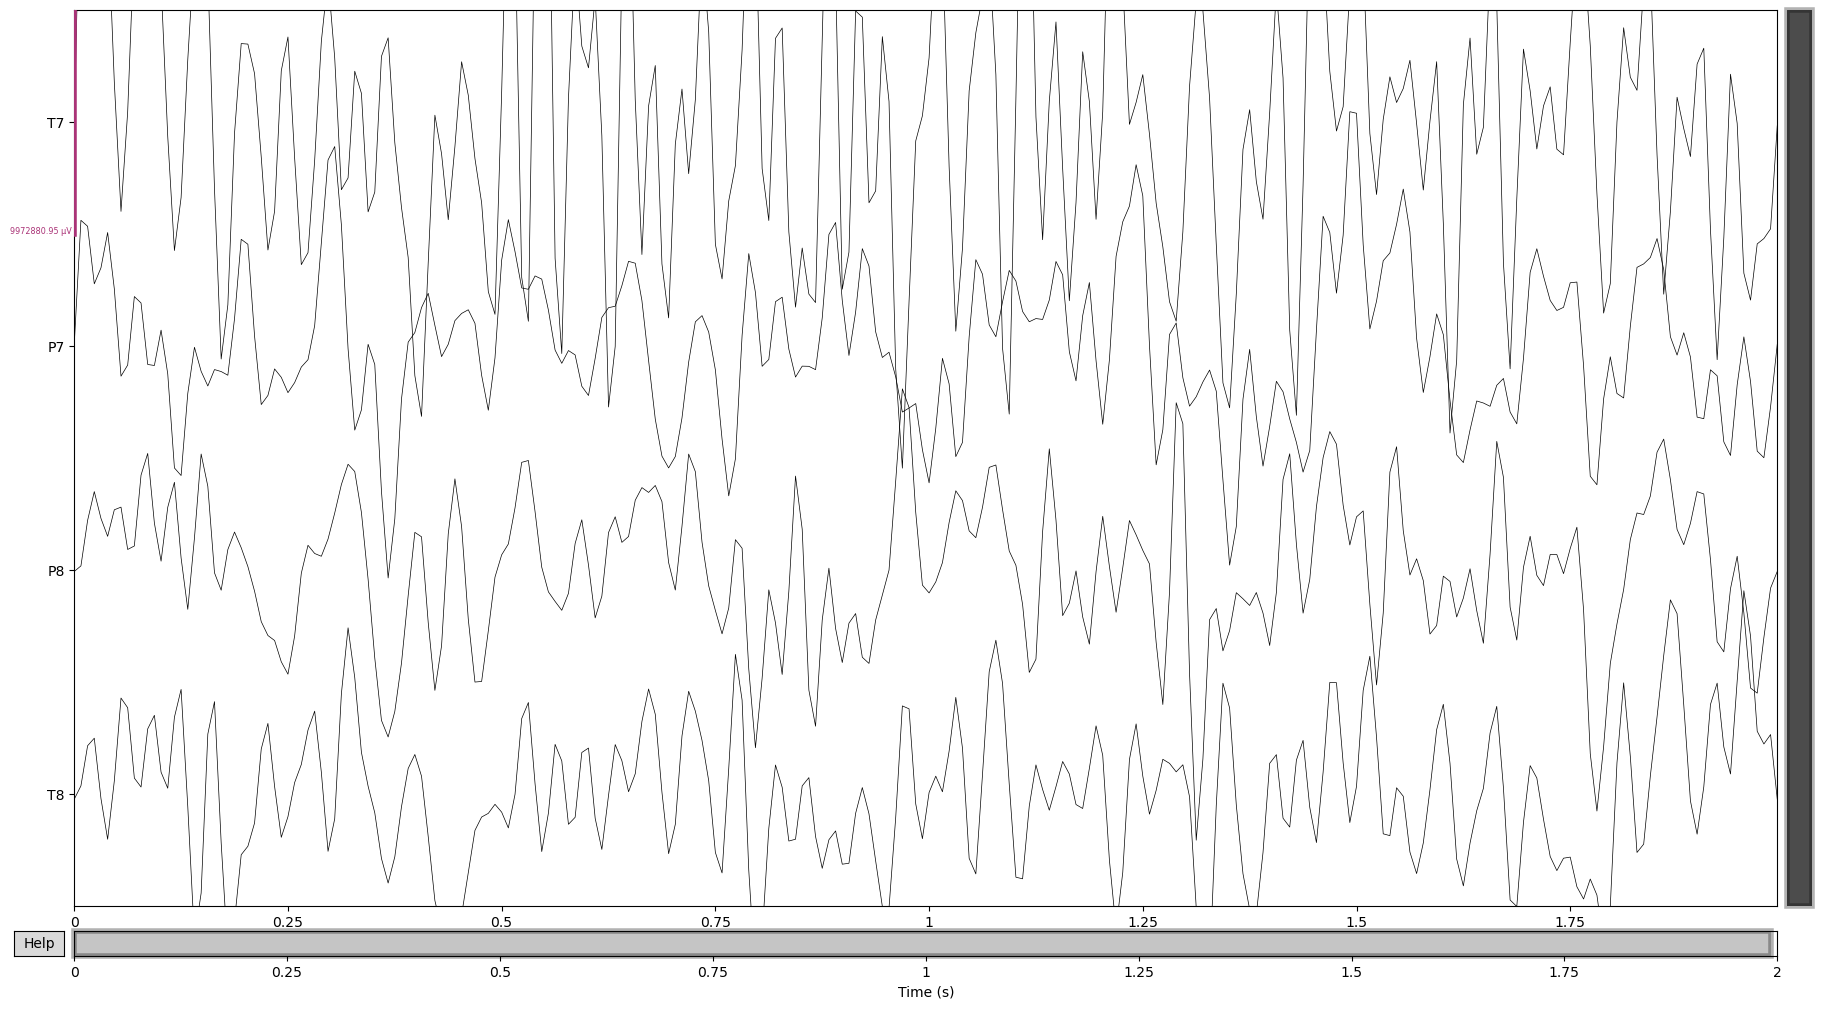

In [205]:
all_points[3].mne_object.plot(scalings='auto')